In [1]:
import numpy as np
import os
import h5py
from getdist import plots, MCSamples
import getdist
import dynesty 
from dynesty import plotting as dyplot
import pickle

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils

In [2]:
pickle_dir = f'../products/dynesty_results'

In [3]:
cwp = 'deepskyblue'
cupf = 'green'
cmcf = 'magenta'

In [4]:
param_labels = {'Omega_m': '\Omega_m', 
                'Omega_b': '\Omega_b', 
                'sigma_8': '\sigma_8', 
                'h': 'h', 
                'n_s': 'n_s',
                'N_eff': 'N_{eff}', 
                'w': 'w', 
                'M_sat': 'M_{sat}', 
                'alpha': r'\alpha', 
                'M_cut': 'M_{cut}', 
                'sigma_logM': '\sigma_{logM}', 
                'v_bc': 'v_{bc}', 
                'v_bs': 'v_{bs}', 
                'c_vir': 'c_{vir}', 
                'f': 'f', 
                'f_env': 'f_{env}', 
                'delta_env': '\delta_{env}', 
                'sigma_env': '\sigma_{env}'}

In [5]:
cosmo_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_params = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f']
ab_params = ['f_env', 'delta_env', 'sigma_env']
hod_interest = ['M_sat', 'M_cut', 'alpha', 'f_env', 'delta_env']
all_interest = ['Omega_m', 'sigma_8', 'M_sat', 'f_env', 'delta_env']
key_params = ['Omega_m', 'sigma_8', 'M_sat', 'v_bc', 'v_bs', 'f', 'f_env']
all_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w', 'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']

In [6]:
def get_h5(chaintag): 
    chain_fn = f'../chains/chains_{chaintag}.h5'
    if os.path.exists(chain_fn):
        fw = h5py.File(chain_fn, 'r')
        #chain_dset = fw['chain']
        #print(f"{chaintag}: {chain_dset}")
        #print(f"dlogz: {fw.attrs['dlogz']}")
        #print(f"seed: {fw.attrs['seed']}")
        return fw
    else:
        print(f"chain {chain_fn} doesn't exist!")

In [7]:
def check_chains(chaintag): 
    chain_fn = f'../chains/chains_{chaintag}.h5'
    if os.path.exists(chain_fn):
        fw = h5py.File(chain_fn, 'r')
        chain_dset = fw['chain']
        print(f"{chaintag}: {chain_dset}")
        print(f"dlogz: {fw.attrs['dlogz']}")
        print(f"seed: {fw.attrs['seed']}")
        fw.close()
    else:
        print(f"chain {chain_fn} doesn't exist!")

In [8]:
def plot_chains(chaintag, show_walkers=False, show_params=None, figure=None, nsteps=None, color='blue'): 
    #chaintag = 'wp_c3h3_Msat_fenv_xlong_diag'
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')

    chain_dset = fw['chain']
    print(chain_dset)
    chain = np.array(chain_dset)
    lnprob_dset = fw['lnprob']
    lnprob = np.array(lnprob_dset)
    param_names = fw.attrs['param_names']
    true_values = fw.attrs['true_values']
    if nsteps:
        chain = chain[:,:nsteps,:]
    fw.close()
    
    if show_params:    
        idxs = []
        for sp in show_params:
            idxs.append(np.where(param_names == sp))
        idxs = np.array(idxs).flatten()
        chain = chain[:,:,idxs]
        param_names = show_params
        true_values = true_values[idxs]

    nwalkers, nchain, ndim = chain.shape

    for k in range(ndim):
        plt.figure()
        pname = param_names[k]
        for j in range(nwalkers):
            plt.title(pname)
            plt.plot(chain[j,:,k], alpha=1)
            low, high = bounds[pname]
            plt.axhline(low, ls=':', color='k')
            plt.axhline(high, ls=':', color='k')
            plt.axhline(true_values[k], ls='-', lw=2, color='k')
    plt.xlabel('step')

    plt.figure()
    for j in range(nwalkers):
        plt.plot(lnprob[j,:], alpha=1)
    plt.ylabel('lnprob')
    plt.xlabel('step')

In [9]:
def plot_contours(chaintags, legend_labels=None, params_toplot=None, nsteps=None, colors=None, 
                  legend_loc='upper center', legend_fontsize=20, weight_with_dynesty=False): 
    
    sample_arr = []
    for i, chaintag in enumerate(chaintags):
        
        resample_chains = False
        if 'dynesty' in chaintag:
            resample_chains = True
            assert not (nsteps!=None and resample_chains), "if resampling, shouldn't be selecting nsteps!"
    
        chain_fn = f'../chains/chains_{chaintag}.h5'
        fw = h5py.File(chain_fn, 'r')

        chain_dset = fw['chain']
        chain = np.array(chain_dset)
        print(chaintag, ':', chain.shape)
        if nsteps:
            chain = chain[:,:nsteps,:]
   
        lnprob_dset = fw['lnprob']  
        param_names = fw.attrs['param_names']
        true_values = fw.attrs['true_values']

        if params_toplot is not None:    
            idxs = []
            for pm in params_toplot:
                idxs.append(np.where(param_names == pm))
            idxs = np.array(idxs).flatten()
            chain = chain[:,:,idxs]
            param_names = params_toplot
            true_values = true_values[idxs]

        nwalkers, nchain, ndim = chain.shape
        
        samples = chain.reshape(-1, chain.shape[-1])
        labels = [param_labels[pn] for pn in param_names]
        ranges = [bounds[pn] for pn in param_names]

        if resample_chains:
            lnweight_dset = fw['lnweight']
            lnevidence_dset = fw['lnevidence']
            #[-1] bc just care about final evidence value
            lnweight = np.array(lnweight_dset)[0] #[0] bc an extra array dim
            lnevidence = np.array(lnevidence_dset)[0]
            weights = np.exp(lnweight - lnevidence[-1]) 
            weights = weights.flatten()
            
            samples = np.empty((nchain, ndim))
            for nd in range(ndim):
                cn = chain[:,:,nd].flatten()
                if weight_with_dynesty:
                    samples[:,nd] = dynesty.utils.resample_equal(cn, weights)
                else:
                    samples[:,nd] = cn
        else:
            weights=None
            
        fw.close()
        
        if weight_with_dynesty:
            weights = None
        
        # have not gotten ranges to work
        samps = MCSamples(names=param_names, labels=labels, ranges=ranges)
        # for some reason get slightly diff answer if don't use setSamples and pass them straight to MCSamples!
        samps.setSamples(samples, weights=weights)
        sample_arr.append(samps)

    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add=0.4
    g.settings.figure_legend_frame = False
    g.settings.legend_fontsize = legend_fontsize
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_color = 'dimgrey'
    g.triangle_plot(sample_arr, filled=True, contour_colors=colors, names=param_names,
                   legend_labels=legend_labels, markers=true_values, title_limit=1, legend_loc=legend_loc,
                   #marker_args={'color': 'orange', 'lw':1.5}
                   )
    return g

In [10]:
def plot_contours_resample(chaintags, legend_labels=None, params_toplot=None, nsteps=None, colors=None, 
                  legend_loc='upper center', legend_fontsize=20, weight_with_dynesty=False, use_res=None): 
    # if not weight_with_dynesty, then weight with MCSamples
    
    if use_res is None:
        use_res = [False]*len(chaintags)
    
    sample_arr = []
    for i, chaintag in enumerate(chaintags):

        chain_fn = f'../chains/chains_{chaintag}.h5'
        fw = h5py.File(chain_fn, 'r')
        print(fw.keys())
        print(fw.attrs.keys())
        
        if use_res[i]:
            pickle_dir = f'../products/dynesty_results'
            pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
            with open(pickle_fn, 'rb') as pf:
                res = pickle.load(pf)
                chain = res['samples']
                lnweight = np.array(res['logwt'])
                lnevidence = np.array(res['logz'])
                
        else:  
            chain_dset = fw['chain']
            chain = np.array(chain_dset)[0]
            lnweight_dset = fw['lnweight']
            lnevidence_dset = fw['lnevidence']
            lnweight = np.array(lnweight_dset)[0] #[0] bc an extra array dim
            lnevidence = np.array(lnevidence_dset)[0]
          
        param_names = fw.attrs['param_names']
        true_values = fw.attrs['true_values']
        
        fw.close()

        if params_toplot is not None:    
            idxs = []
            for pm in params_toplot:
                idxs.append(np.where(param_names == pm))
            idxs = np.array(idxs).flatten()
            chain = chain[:,idxs]
            param_names = params_toplot
            true_values = true_values[idxs]
        
        nchain, ndim = chain.shape
        print(nchain, ndim)
        samples = chain.reshape(-1, ndim)
        labels = [param_labels[pn] for pn in param_names]
        ranges = [bounds[pn] for pn in param_names]

        #[-1] bc just care about final evidence value
        weights = np.exp(lnweight - lnevidence[-1]) 
        weights = weights.flatten()

        samples = np.empty((nchain, ndim))
        for nd in range(ndim):
            cn = chain[:,nd].flatten()
            if weight_with_dynesty:
                samples[:,nd] = dynesty.utils.resample_equal(cn, weights)
            else:
                samples[:,nd] = cn
        
        if weight_with_dynesty:
            weights = None
        
        # have not gotten ranges to work
        samps = MCSamples(names=param_names, labels=labels)#, ranges=ranges)
        # for some reason get slightly diff answer if don't use setSamples and pass them straight to MCSamples!
        print(samples.shape, weights.shape)
        samps.setSamples(samples, weights=weights)
        sample_arr.append(samps)

    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add=0.4
    g.settings.figure_legend_frame = False
    g.settings.legend_fontsize = legend_fontsize
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_color = 'dimgrey'
    g.triangle_plot(sample_arr, filled=True, contour_colors=colors, names=param_names,
                   legend_labels=legend_labels, markers=true_values, title_limit=1, legend_loc=legend_loc,
                   )
    return g

In [11]:
def plot_weights(chaintag): 
    
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')
    
    lnweight_dset = fw['lnweight']
    lnevidence_dset = fw['lnevidence']
    #[-1] bc just care about final evidence value
    
    lnweight = np.array(lnweight_dset)[0] #bc accidentally a an extra array dim
    lnevidence = np.array(lnevidence_dset)[0]
    weights = np.exp(lnweight - lnevidence[-1]) 

    fw.close()

    plt.figure()
    plt.plot(weights)
    plt.xlabel('sample number')
    plt.ylabel('weight')

In [12]:
bounds = utils.get_emulator_bounds()

# back to emcee

In [13]:
check_chains('wp_c3h3_omegam_emcee_hpriore')

wp_c3h3_omegam_emcee_hpriore: <HDF5 dataset "chain": shape (10, 5000, 1), type "<f4">
dlogz: nan
seed: 12


wp_c3h3_omegam_emcee : (10, 5000, 1)
wp_c3h3_omegam_emcee_hpriore : (10, 5000, 1)


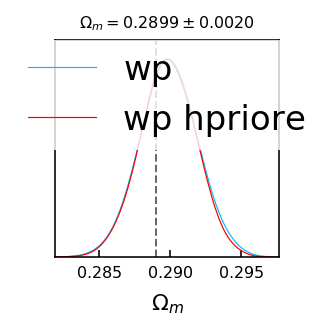

In [14]:
legend_labels = ['wp', 'wp hpriore']
chaintags = ['wp_c3h3_omegam_emcee',
             'wp_c3h3_omegam_emcee_hpriore']
colors = [cwp, 'red']
figure = plot_contours(chaintags, colors=colors,
                      legend_labels=legend_labels)

<HDF5 dataset "chain": shape (10, 5000, 1), type "<f4">


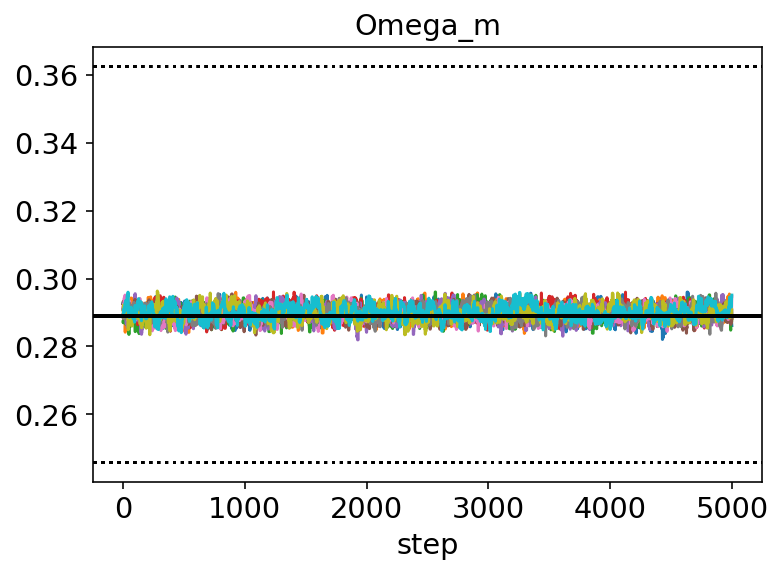

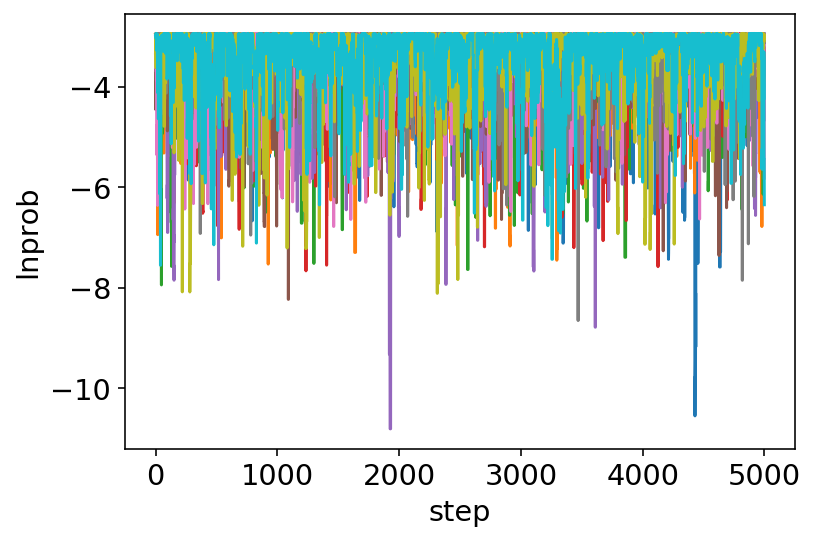

In [15]:
plot_chains('wp_c3h3_omegam_emcee_hpriore')

<HDF5 dataset "chain": shape (10, 5000, 1), type "<f4">


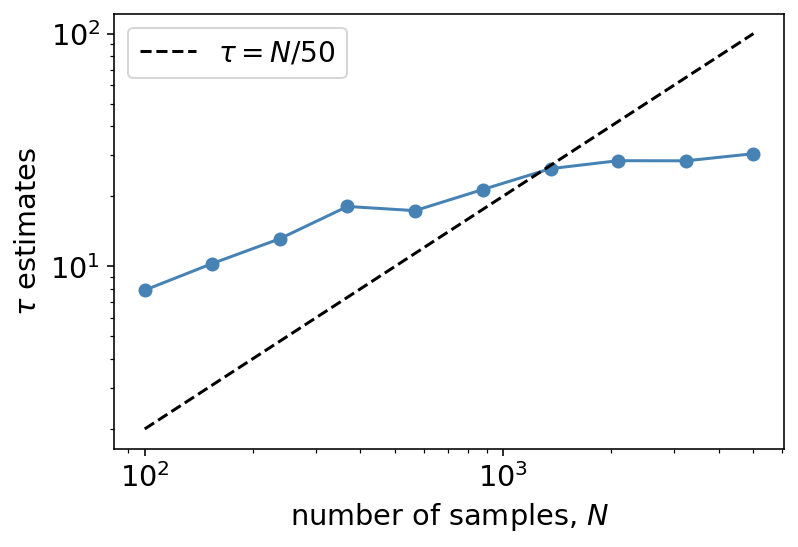

In [16]:
chain = utils.load_chains('wp_c3h3_omegam_emcee')
utils.plot_autocorr(chain)

<HDF5 dataset "chain": shape (10, 5000, 1), type "<f4">


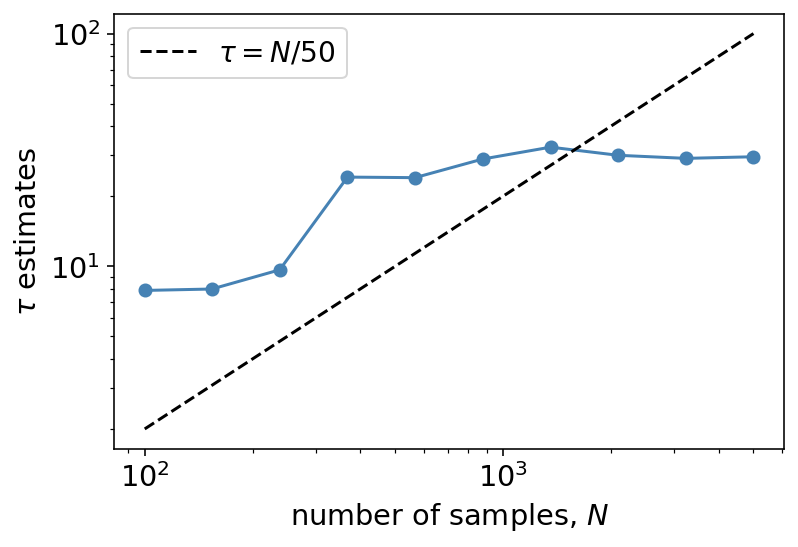

In [17]:
chain = utils.load_chains('wp_c3h3_omegam_emcee_hpriore')
utils.plot_autocorr(chain)

## allcosmo

wp_allcosmo_c3h3_omegam_emcee : (100, 20000, 7)
wp_c3h3_allcosmo_emcee_hpriore : (100, 25000, 7)


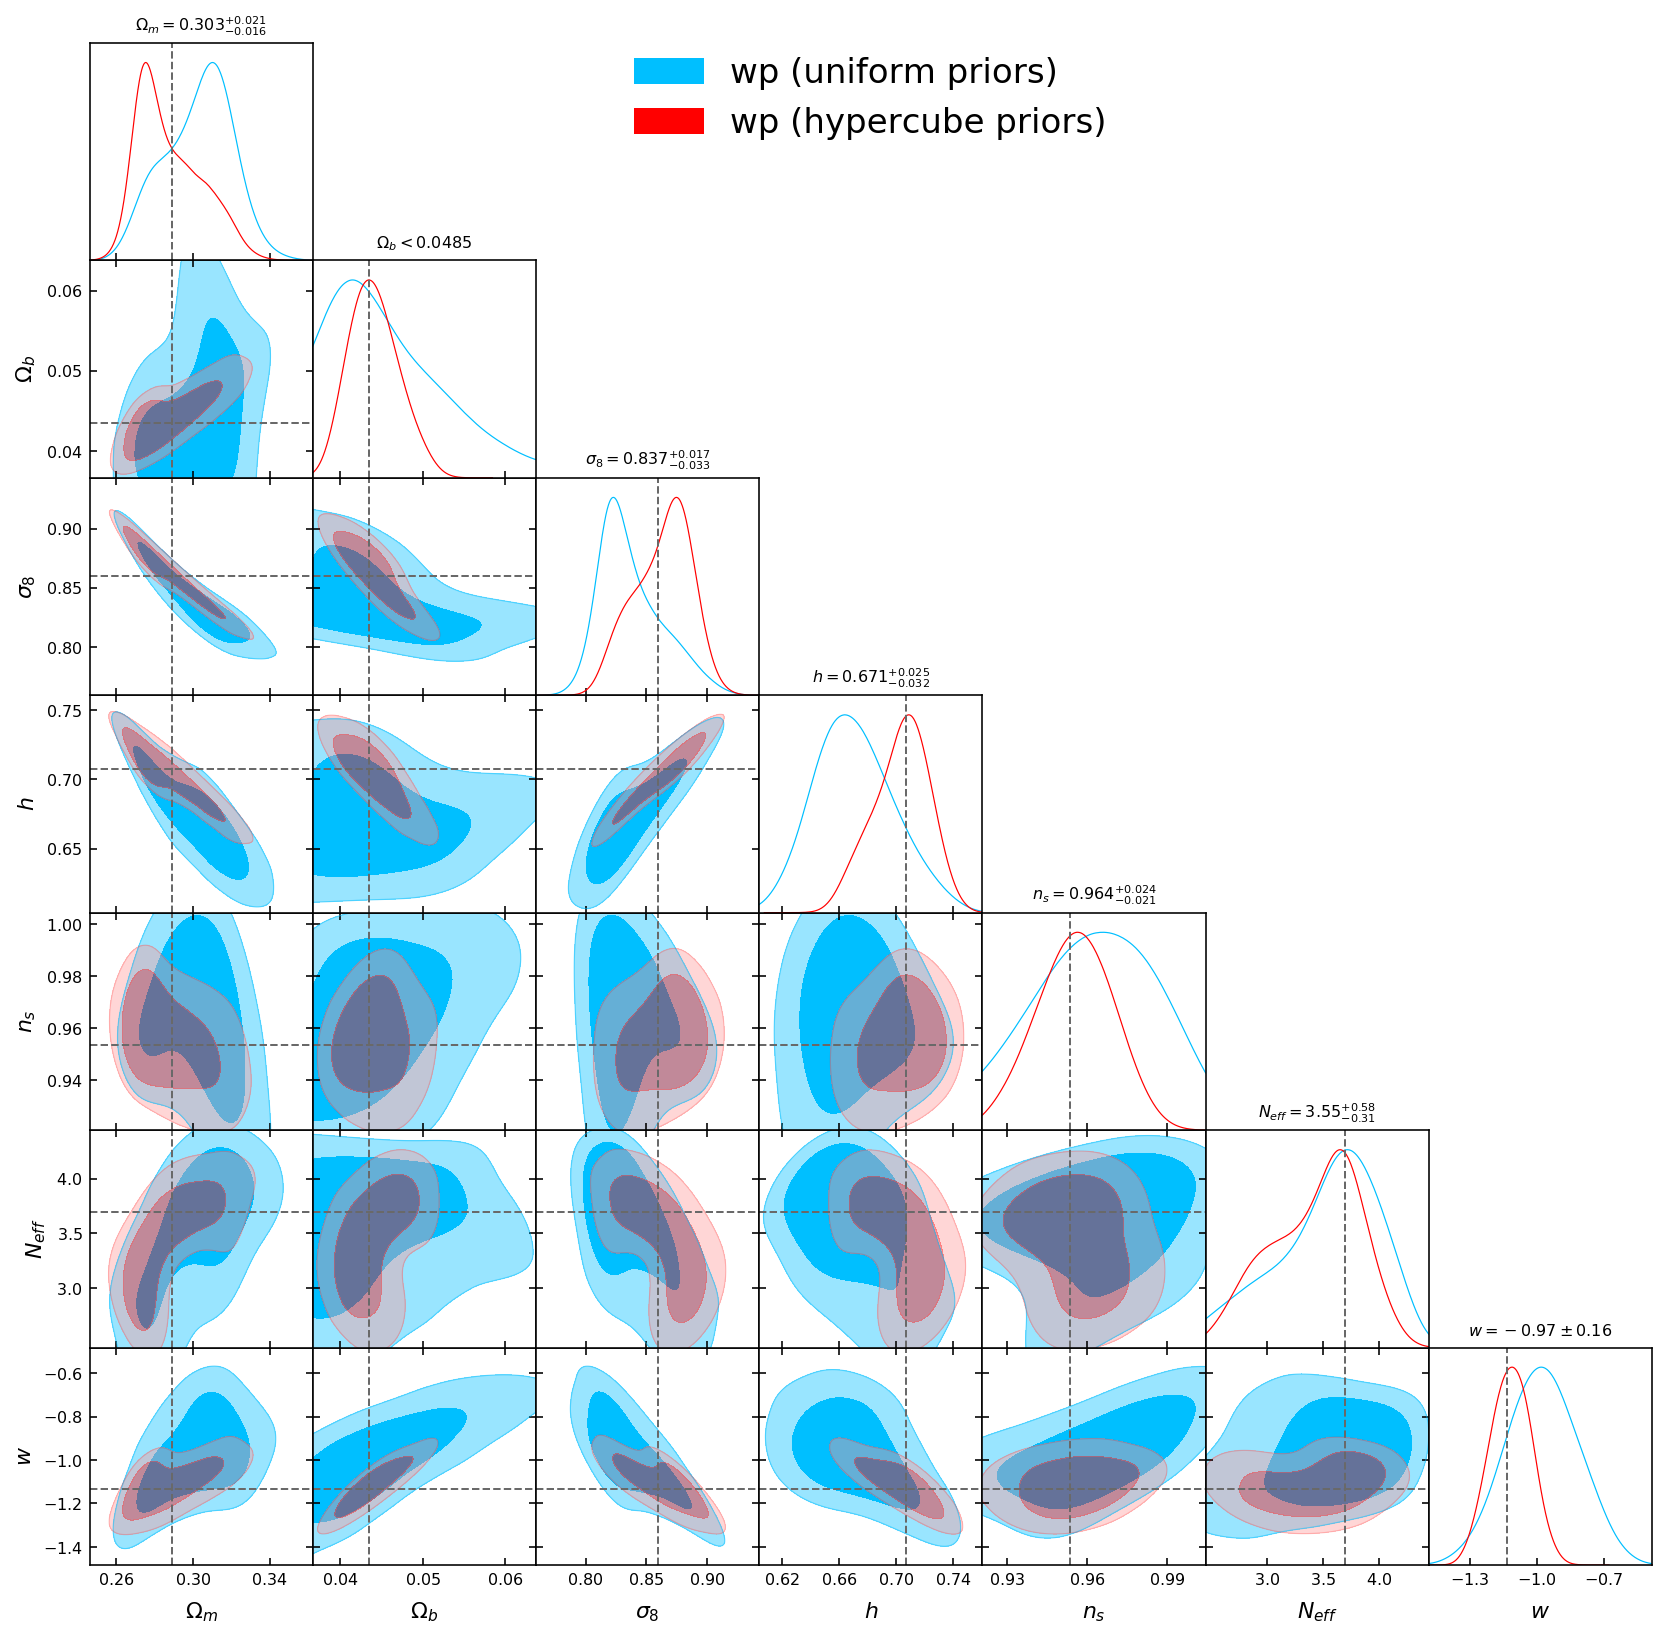

In [13]:
legend_labels = ['wp (uniform priors)', 'wp (hypercube priors)']
# FIX TO 'wp_c3h3_allcosmo_emcee'
chaintags = ['wp_allcosmo_c3h3_omegam_emcee',
             'wp_c3h3_allcosmo_emcee_hpriore'
            ]
colors = [cwp, 'red']
figure = plot_contours(chaintags, colors=colors,
                      legend_labels=legend_labels)

<HDF5 dataset "chain": shape (100, 20000, 7), type "<f4">


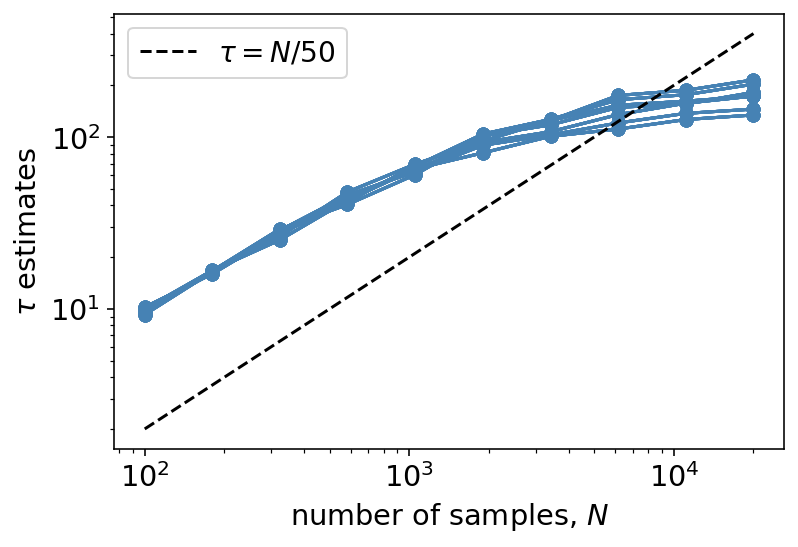

In [14]:
# FIX TO 'wp_c3h3_allcosmo_emcee'
chain = utils.load_chains('wp_allcosmo_c3h3_omegam_emcee')
utils.plot_autocorr(chain)

<HDF5 dataset "chain": shape (100, 25000, 7), type "<f4">


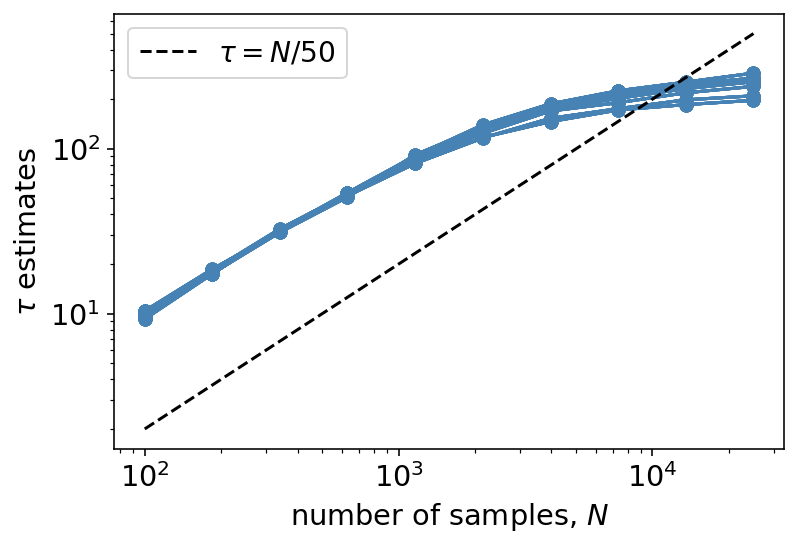

In [15]:
chain = utils.load_chains('wp_c3h3_allcosmo_emcee_hpriore')
utils.plot_autocorr(chain)

### all

wp_c3h3_all_emcee : (250, 63100, 18)
wp_c3h3_all_emcee_hpriore : (250, 66200, 18)


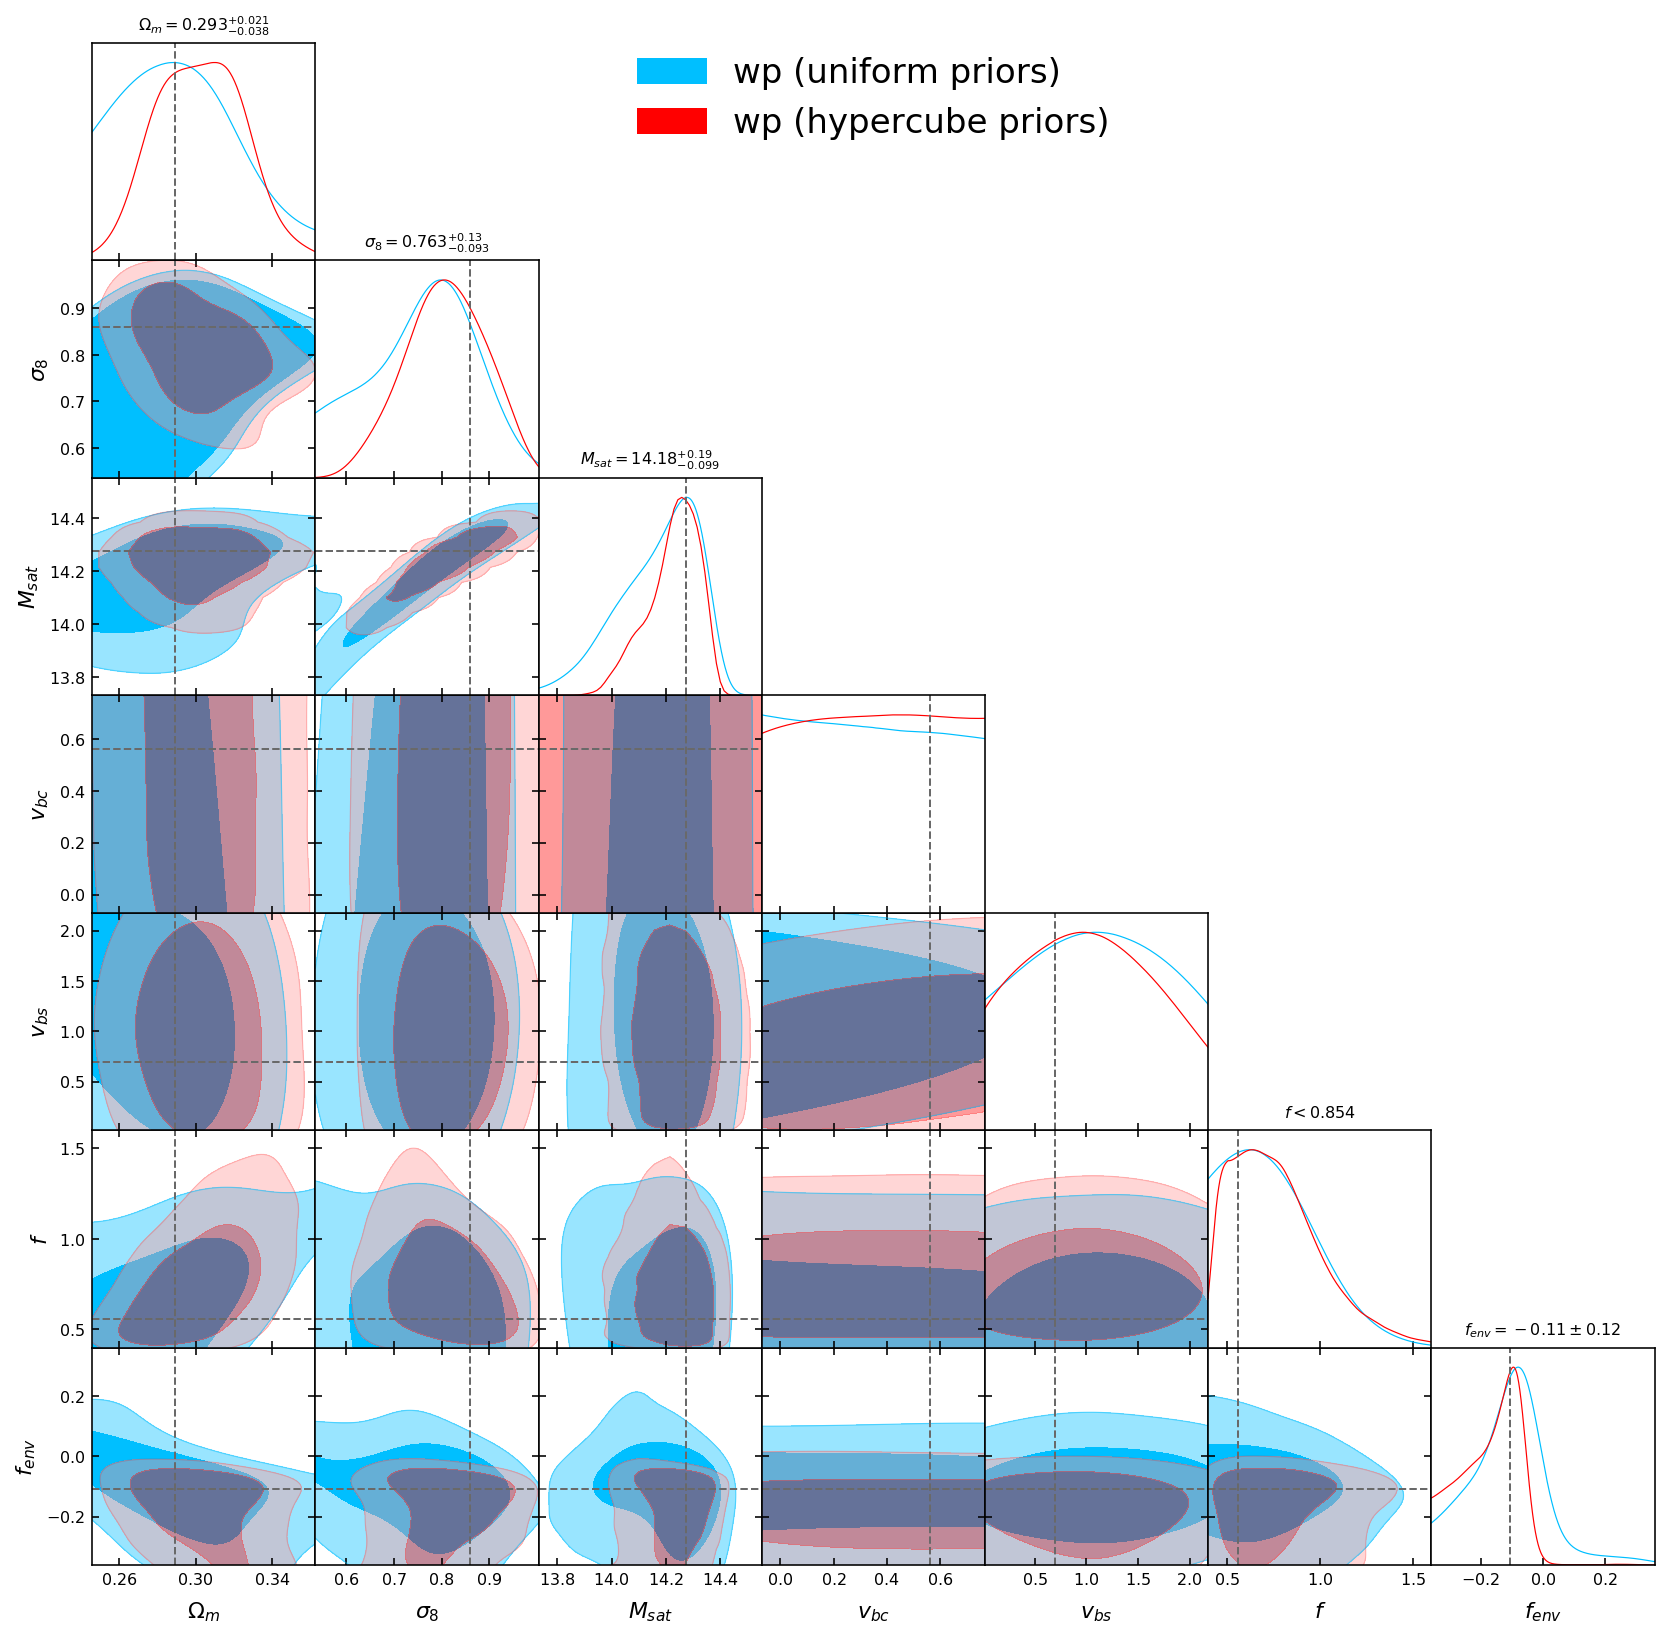

In [13]:
legend_labels = ['wp (uniform priors)', 'wp (hypercube priors)']
# FIX TO 'wp_c3h3_all_emcee'
chaintags = ['wp_c3h3_all_emcee',
             'wp_c3h3_all_emcee_hpriore'
            ]
colors = [cwp, 'red']
figure = plot_contours(chaintags, colors=colors, params_toplot=key_params,
                      legend_labels=legend_labels)

<HDF5 dataset "chain": shape (250, 63100, 18), type "<f4">


/home/users/ksf293/emulator/code/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/home/users/ksf293/emulator/code/utils.py:97: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus


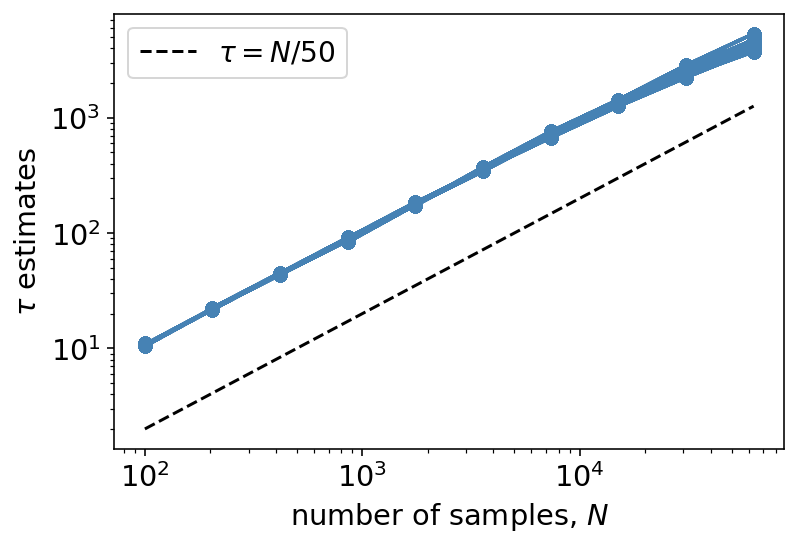

In [14]:
chain = utils.load_chains('wp_c3h3_all_emcee')
utils.plot_autocorr(chain)

<HDF5 dataset "chain": shape (250, 66300, 18), type "<f4">


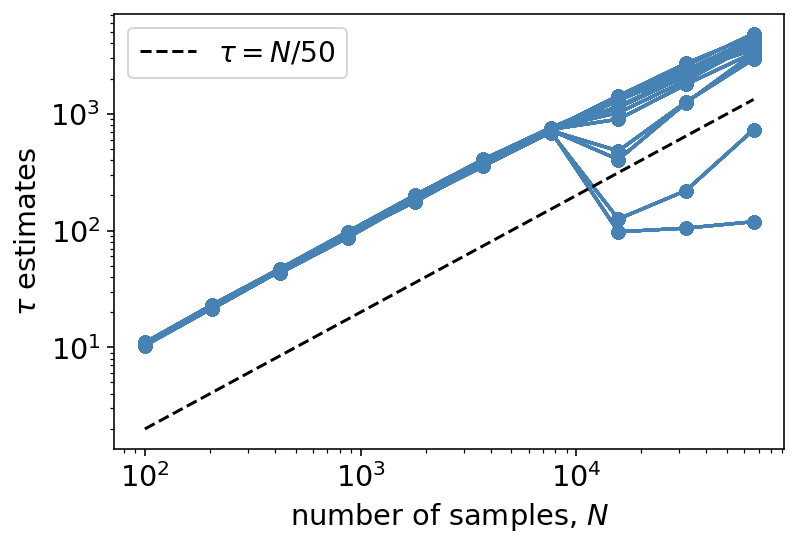

In [15]:
chain = utils.load_chains('wp_c3h3_all_emcee_hpriore')
utils.plot_autocorr(chain)

wp_xi_upf_mcf_c3h3_all_emcee_hpriore : (250, 9500, 18)


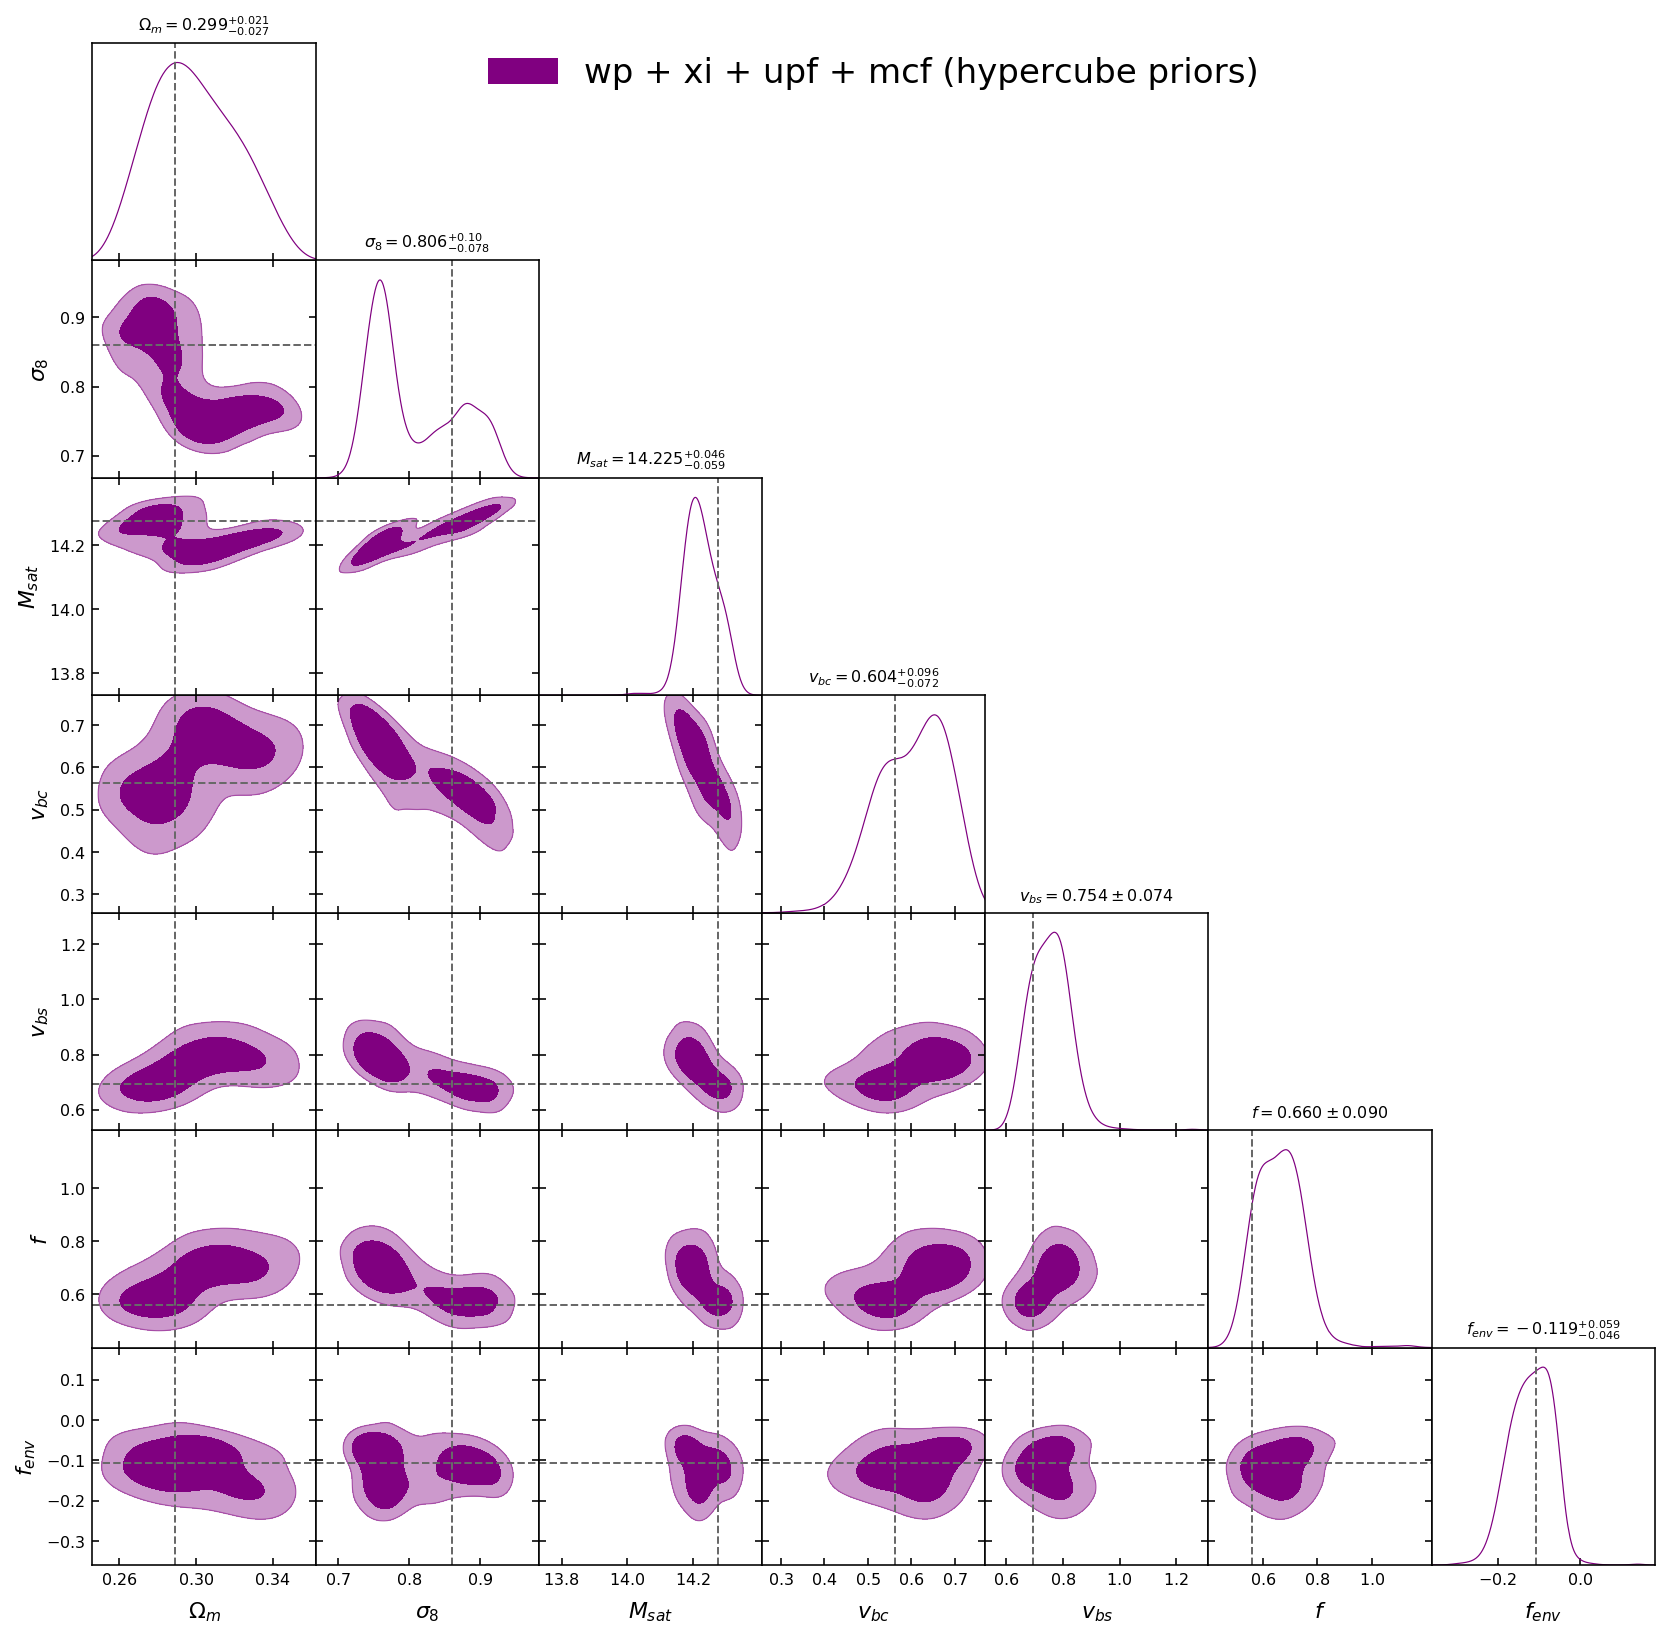

In [16]:
legend_labels = ['wp + xi + upf + mcf (hypercube priors)']
chaintags = ['wp_xi_upf_mcf_c3h3_all_emcee_hpriore',
            ]
colors = ['purple']
figure = plot_contours(chaintags, colors=colors, params_toplot=key_params,
                      legend_labels=legend_labels)

<HDF5 dataset "chain": shape (250, 9500, 18), type "<f4">


/home/users/ksf293/emulator/code/utils.py:90: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/home/users/ksf293/emulator/code/utils.py:97: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus


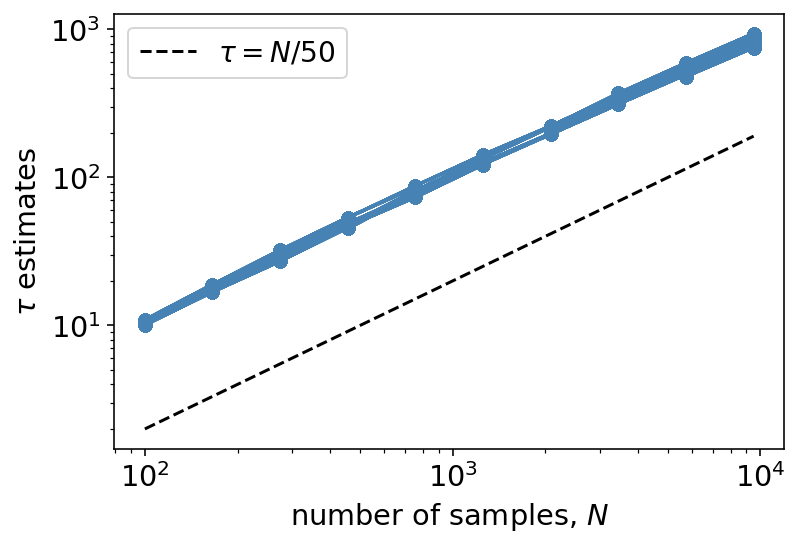

In [17]:
chain = utils.load_chains('wp_xi_upf_mcf_c3h3_all_emcee_hpriore')
utils.plot_autocorr(chain)

wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg : (1, 49532, 18)
wp_xi_upf_mcf_c3h3_all_emcee_hpriore : (250, 9700, 18)


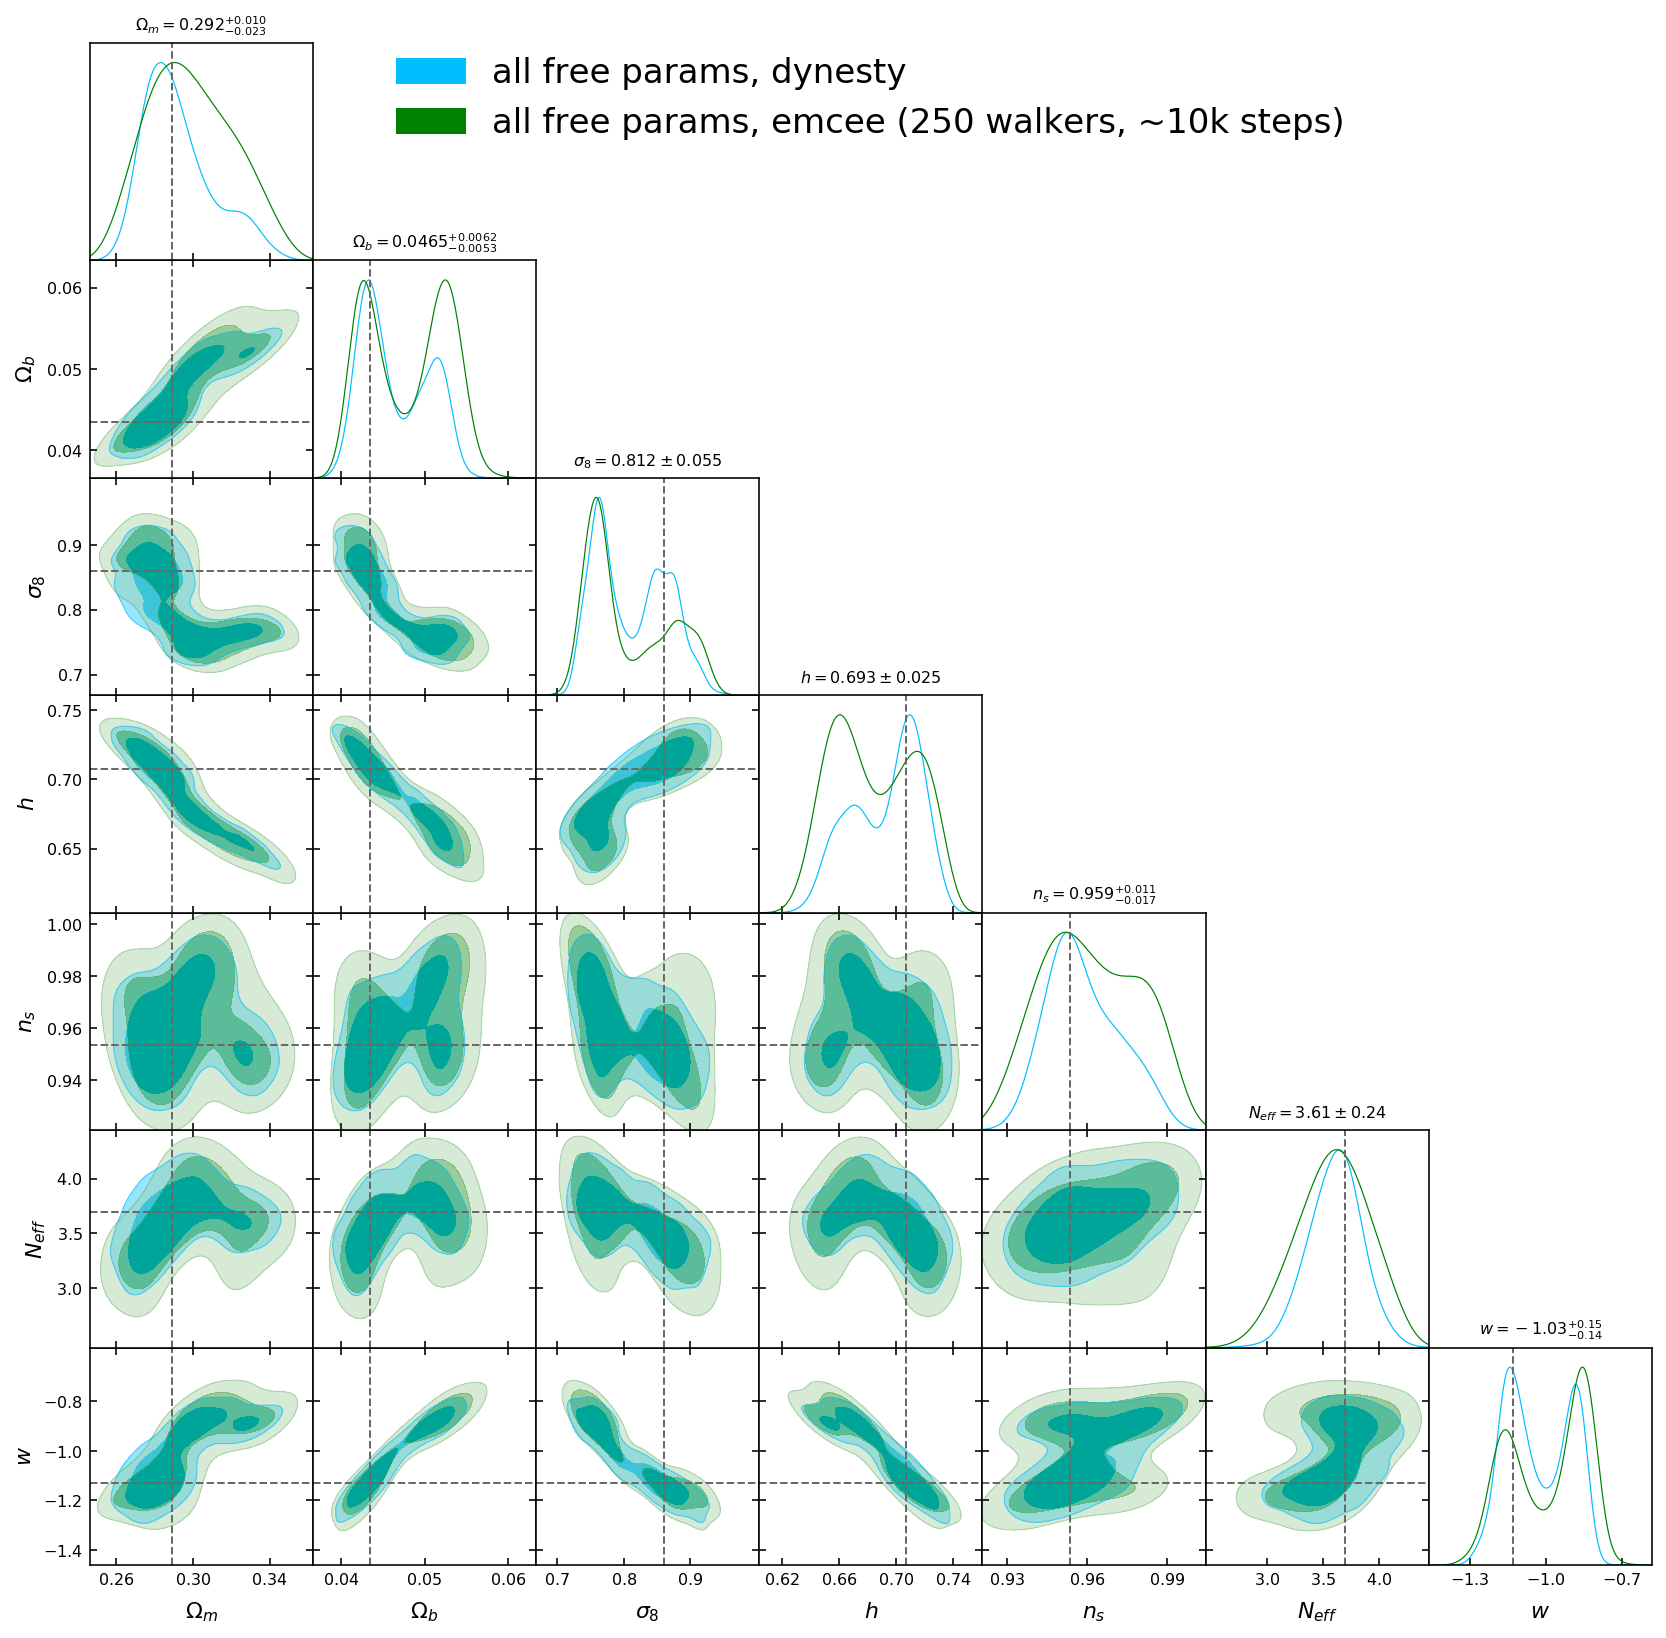

In [19]:
# checking that plotting from res is same
legend_labels = ['all free params, dynesty',
                 'all free params, emcee (250 walkers, ~10k steps)',
                ]
chaintags = ['wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_xi_upf_mcf_c3h3_all_emcee_hpriore',
             ]
colors = [cwp, 'green']
figure = plot_contours(chaintags, colors=colors,
                      legend_labels=legend_labels, params_toplot=cosmo_params)

wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg : (1, 49532, 18)
wp_xi_upf_mcf_c3h3_all_emcee_hpriore : (250, 9800, 18)


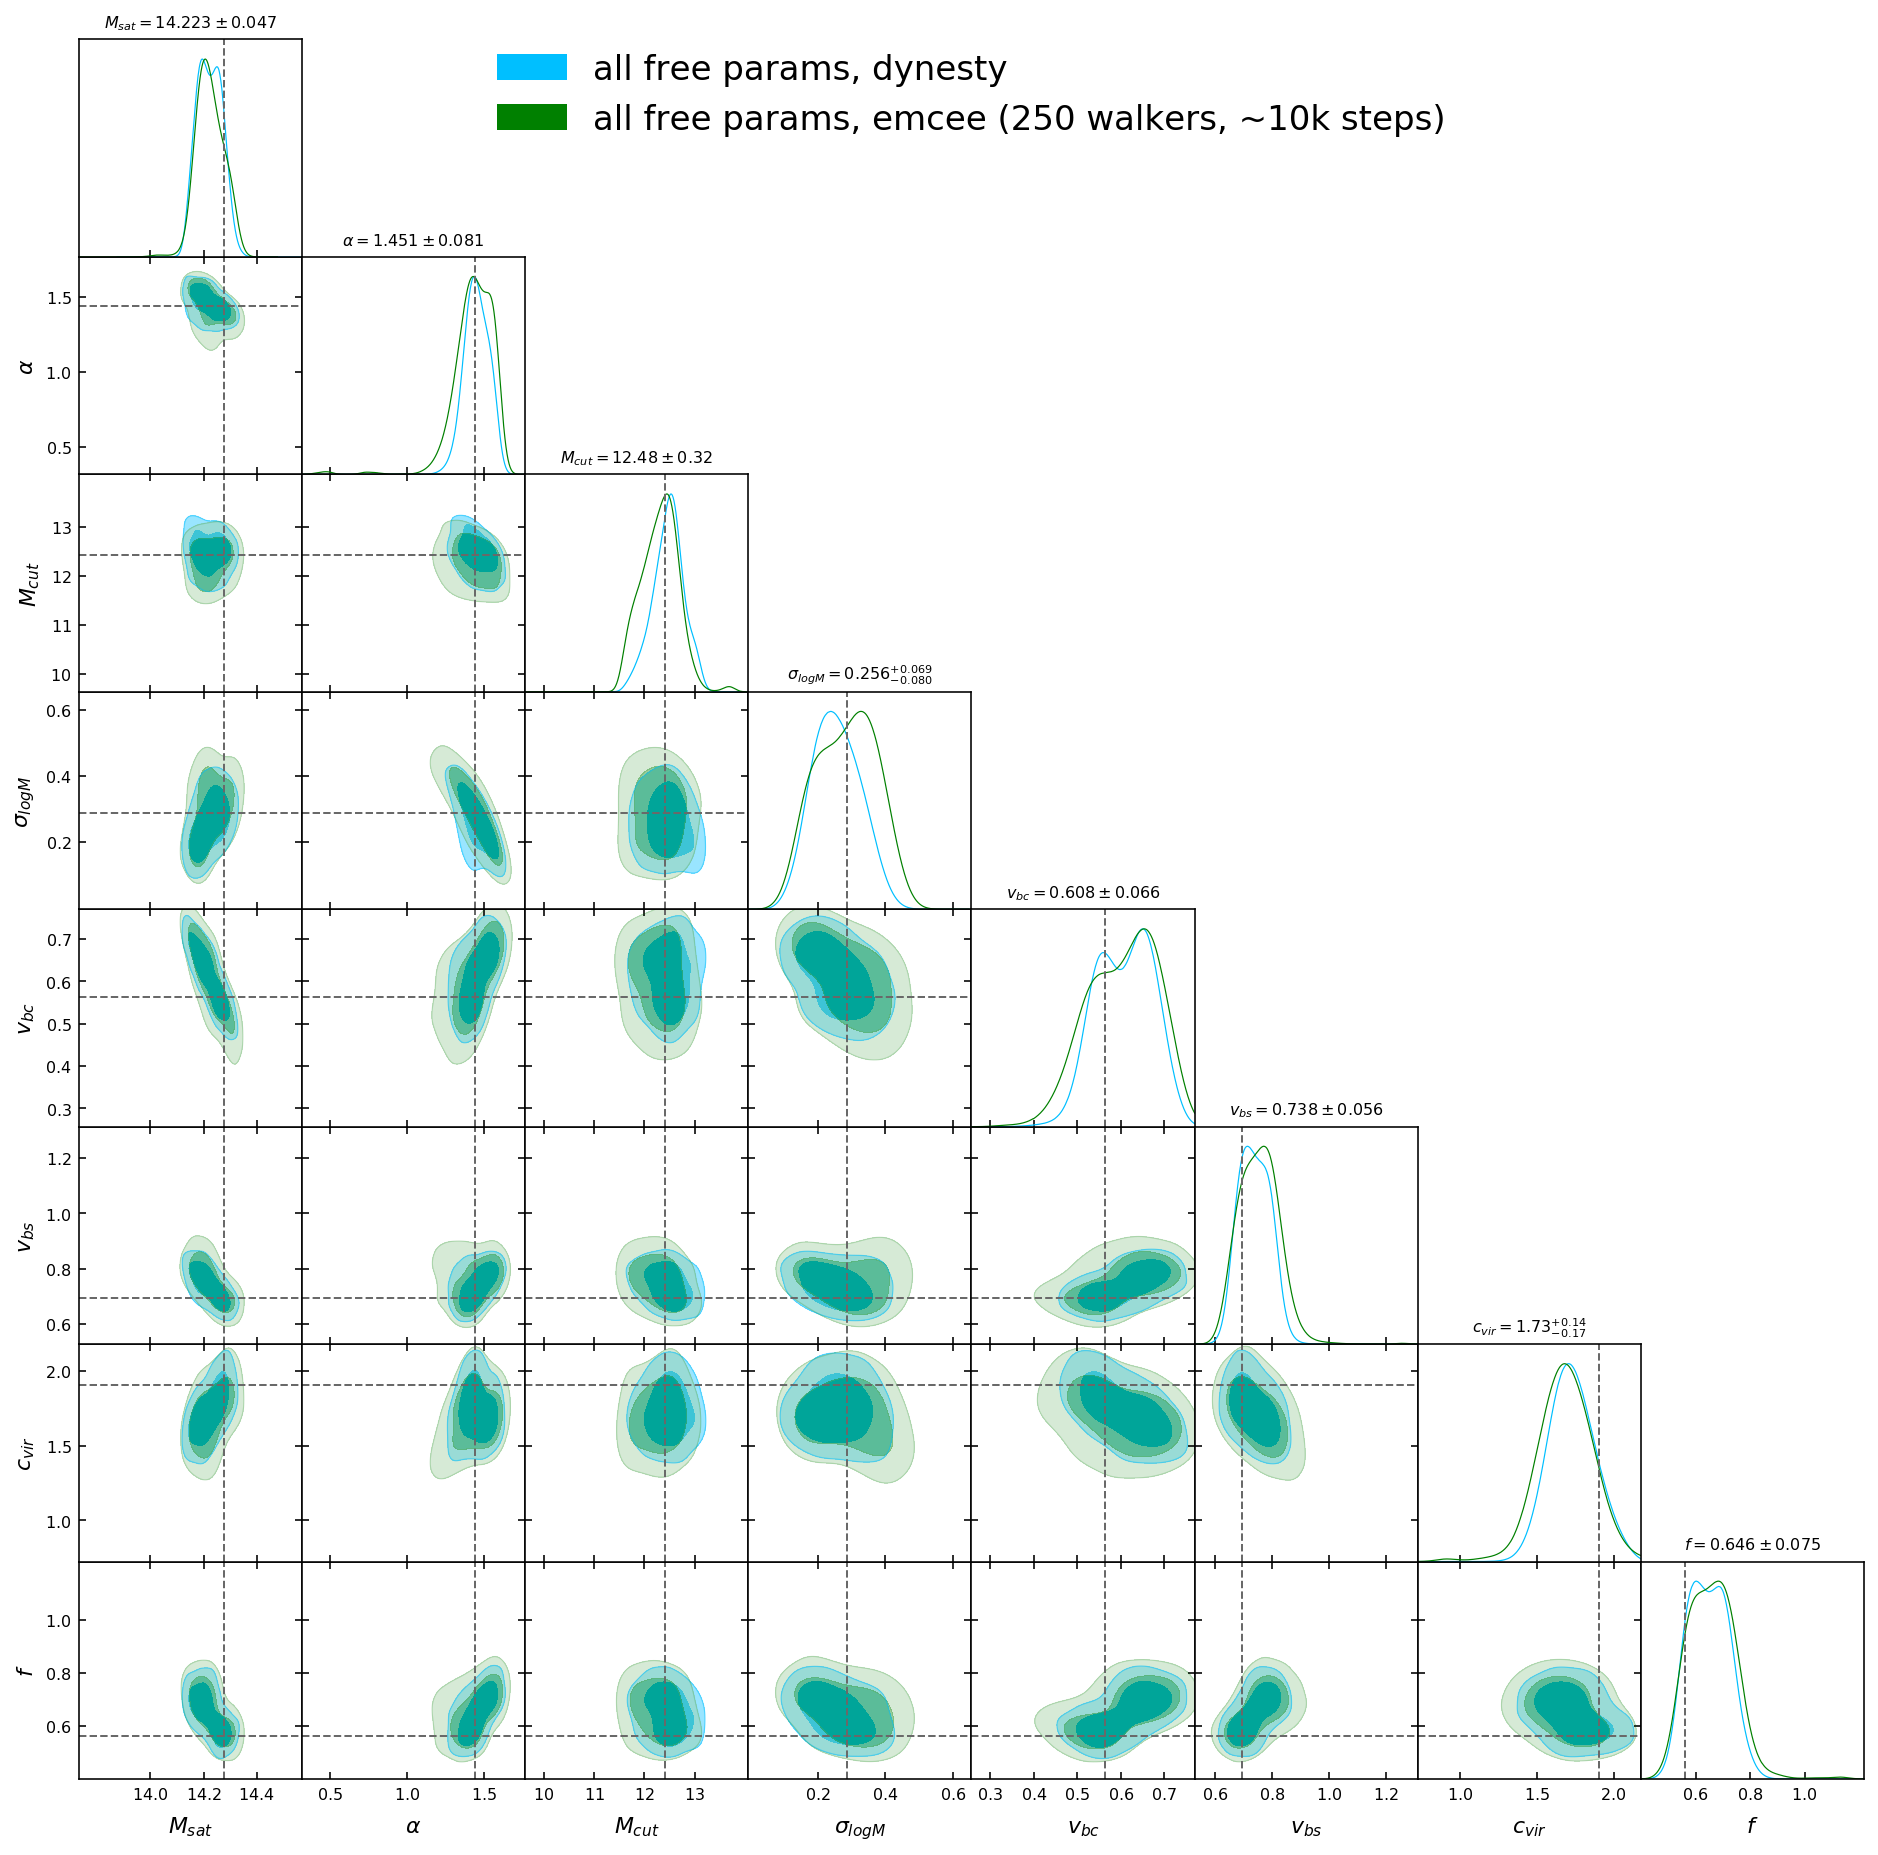

In [22]:
# checking that plotting from res is same
legend_labels = ['all free params, dynesty',
                 'all free params, emcee (250 walkers, ~10k steps)',
                ]
chaintags = ['wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_xi_upf_mcf_c3h3_all_emcee_hpriore',
             ]
colors = [cwp, 'green']
figure = plot_contours(chaintags, colors=colors,
                      legend_labels=legend_labels, params_toplot=hod_params)

wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg : (1, 49532, 18)
wp_xi_upf_mcf_c3h3_all_emcee_hpriore : (250, 9700, 18)


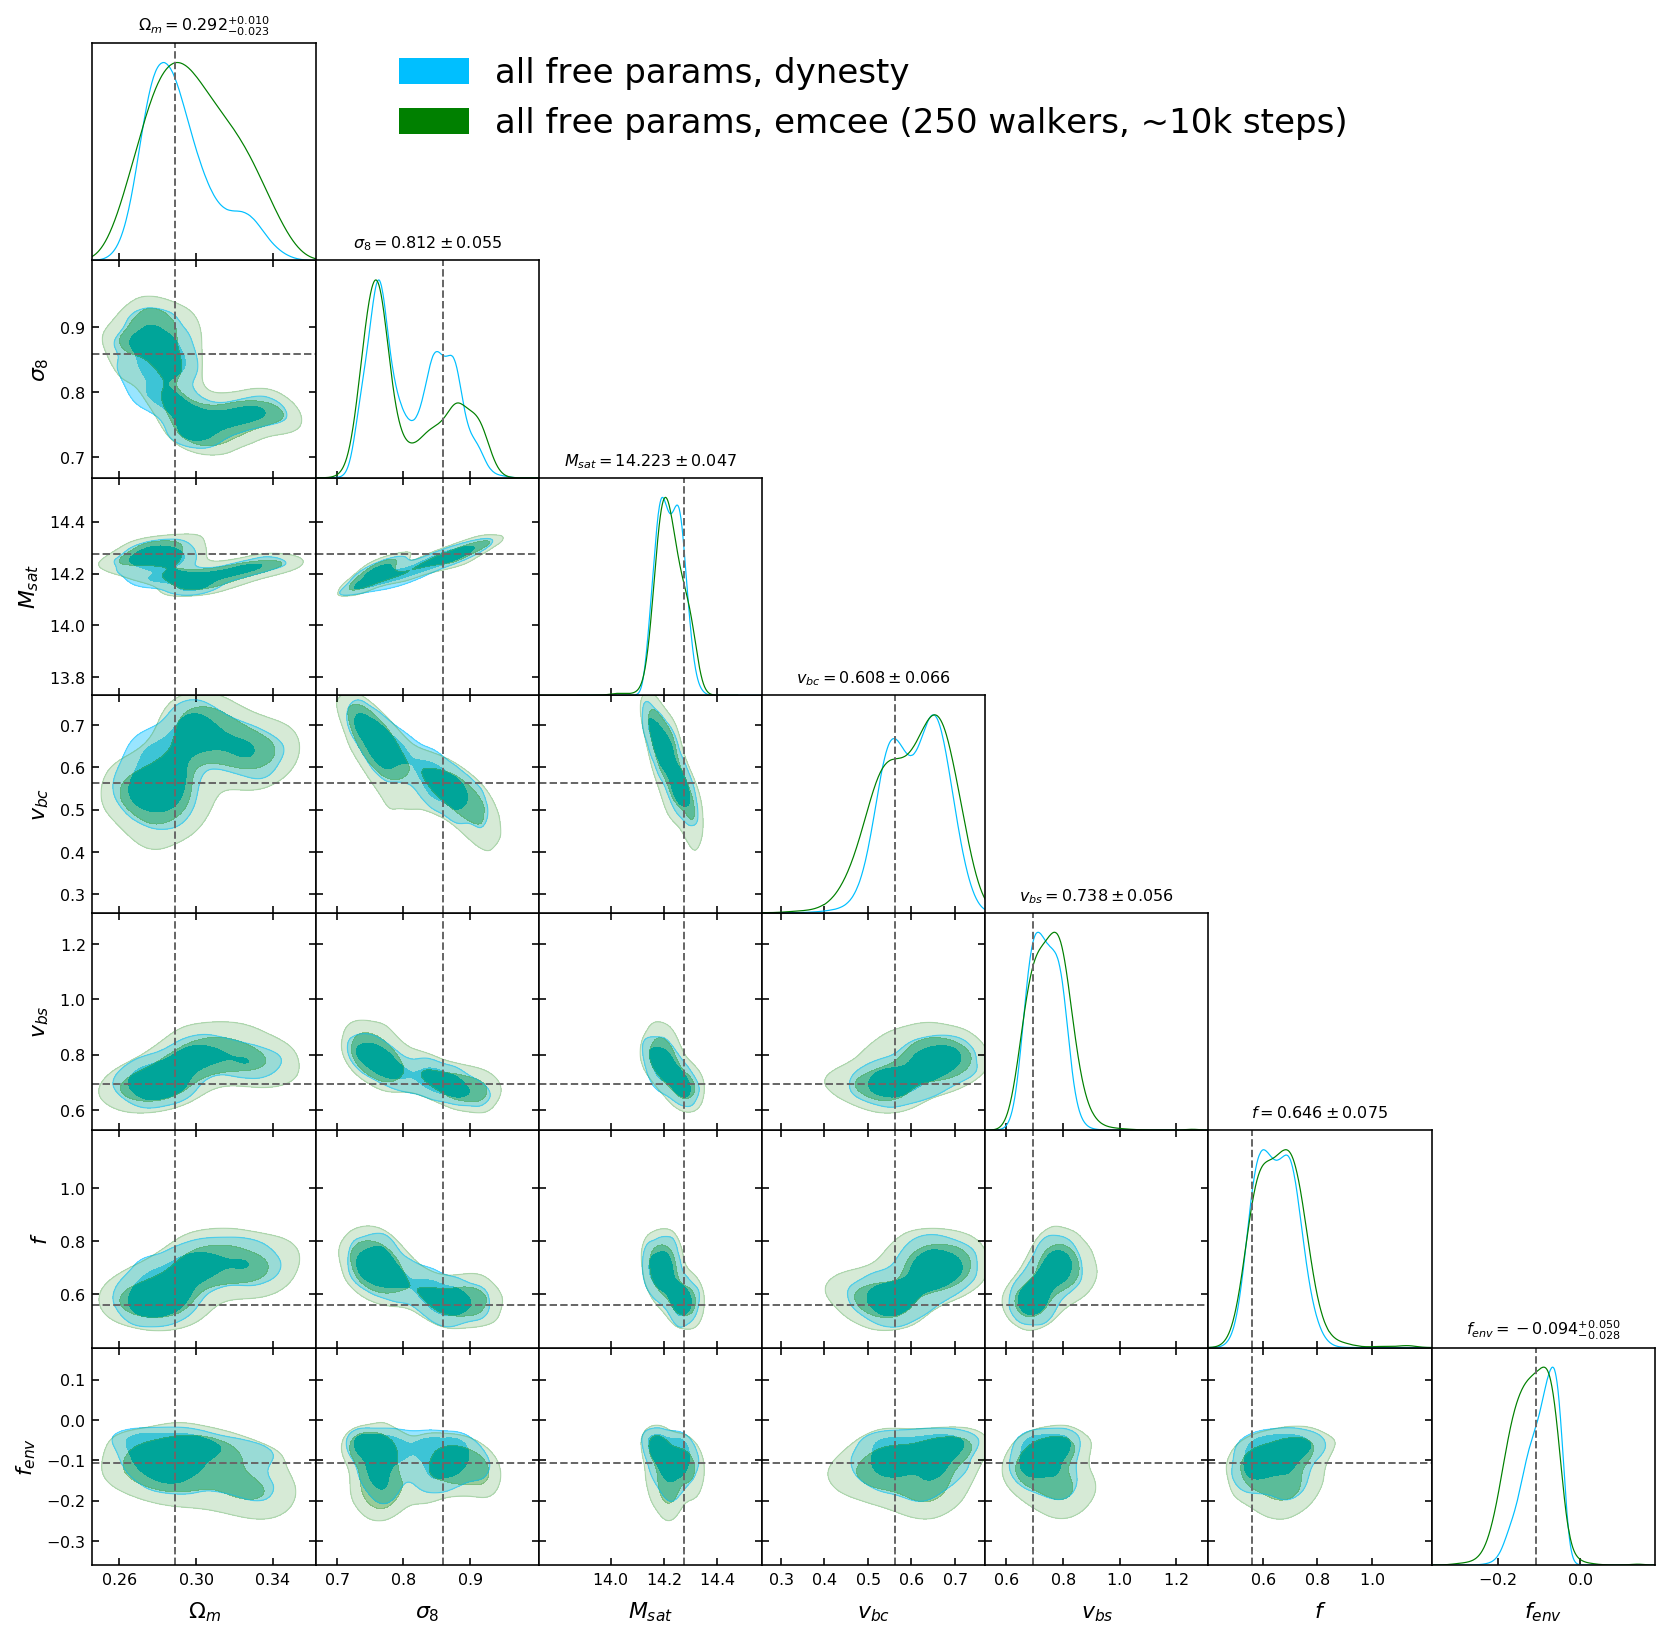

In [20]:
# checking that plotting from res is same
legend_labels = ['all free params, dynesty',
                 'all free params, emcee (250 walkers, ~10k steps)',
                ]
chaintags = ['wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_xi_upf_mcf_c3h3_all_emcee_hpriore',
             ]
colors = [cwp, 'green']
figure = plot_contours(chaintags, colors=colors,
                      legend_labels=legend_labels, params_toplot=key_params)

wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg : (1, 49532, 18)
wp_xi_upf_mcf_c3h3_all_emcee_hpriore : (250, 9800, 18)


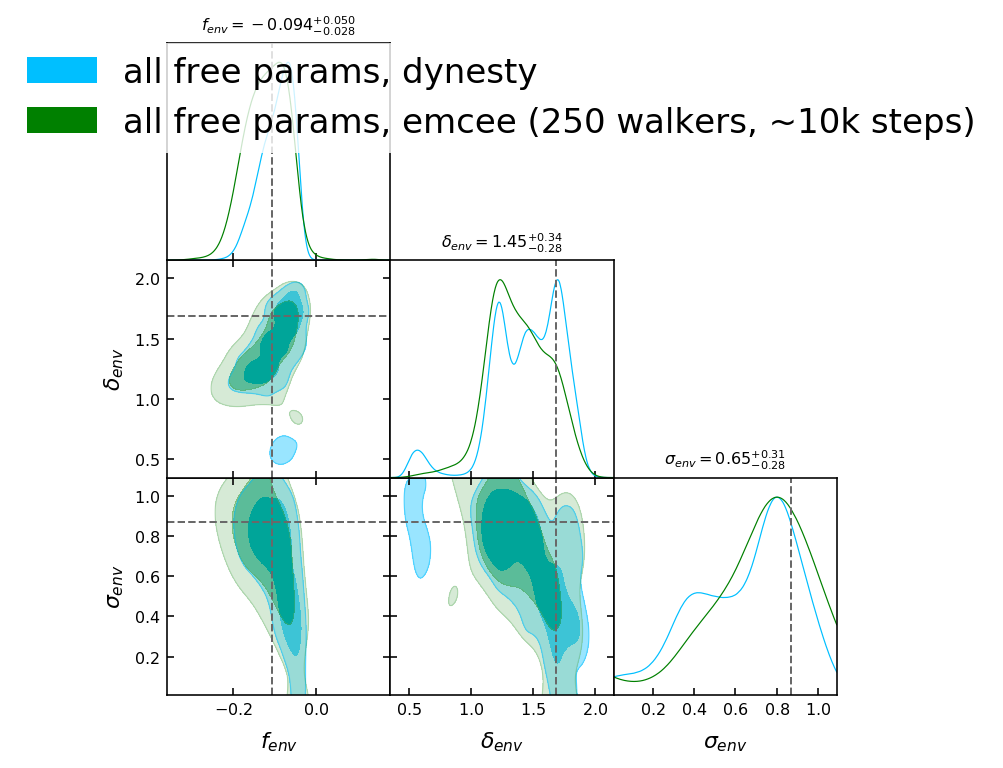

In [23]:
# checking that plotting from res is same
legend_labels = ['all free params, dynesty',
                 'all free params, emcee (250 walkers, ~10k steps)',
                ]
chaintags = ['wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_xi_upf_mcf_c3h3_all_emcee_hpriore',
             ]
colors = [cwp, 'green']
figure = plot_contours(chaintags, colors=colors,
                      legend_labels=legend_labels, params_toplot=ab_params)

In [21]:

# checking that plotting from res is same
legend_labels = ['4 obs, original',
                 '4 obs, original, hypercube prior',
                 '4 obs, new, gen',
                 '4 obs, new, gaussian hypercube prior']
chaintags = ['wp_xi_upf_mcf_c3h3_all_dynesty_dlogz001_seed12',
             'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz0001_hprior',
             'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_gen',
             'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg']
colors = [cwp, 'purple', 'teal', 'orange']
figure = plot_contours(chaintags, colors=colors,
                      legend_labels=legend_labels, params_toplot=cosmo_params)

wp_xi_upf_mcf_c3h3_all_dynesty_dlogz001_seed12 : (1, 21000, 18)
wp_xi_upf_mcf_c3h3_all_dynesty_dlogz0001_hprior : (0, 0, 18)


IndexError: index 0 is out of bounds for axis 0 with size 0